2020-07-15 13:21:54,692 WARNING:matplotlib.backends.backend_ps The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2020-07-15 13:21:54,693 WARNING:matplotlib.backends.backend_ps The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


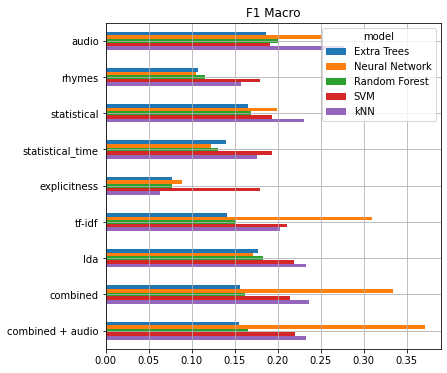

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from nlp4musa2020.analytics import get_best_results
from nlp4musa2020.analytics import plot_best_results

def get_model(df):
    
    def extract_model(value):
        model = value['model']
               
        if model.endswith('Classifier'):
            model = model[:-10]
        
        if model == 'KNeighbors':
            model = 'kNN'
        elif model == 'MultiOutput':
            model = 'SVM'
        elif model == 'RandomForest':
            return 'Random Forest'
        elif model == 'ExtraTrees':
            return 'Extra Trees'
        elif model == 'SimpleGenreNN':
            return 'Neural Network'
        
        return model
    
    return df['pipeline'].apply(extract_model)

def get_feature_groups(df):
    return df['dataloader'].apply(lambda x: x['load_feature_groups'])

def filter_list(f):
    all_features = set(['explicitness', 'rhymes', 'statistical', 'statistical_time', 'lda', 'tf-idf'])

    if all_features.issubset(set(f)):
        return ['combined'] + sorted(list(set(f) - all_features))
    else:
        return f
    
    
def get_vectorizers(df):
    def vectorizer_to_string(v):
        if v == 'None':
            return []
        
        if 'LDAVectorizer' in v and 'TfidfVectorizer' in v:
            return ['lda', 'tf-idf']

        if 'LDAVectorizer' in v:
            return ['lda']

        if 'TfidfVectorizer' in v:
            return ['tf-idf']

        if 'CountVectorizer' in v:
            return ['n-gram']
        else:
            return [v]
        
    return df['dataloader'].apply(lambda x: vectorizer_to_string(x['text_vectorizers']))

def get_features(df):
    return (get_feature_groups(df) + get_vectorizers(df)).apply(filter_list)

score_name = 'f1_macro'
score = 'mean_test_' + score_name

best_results = get_best_results(score_name)

model_params = [p for p in best_results.columns if p.startswith('model__')]
import math
def combine(x):
    result = []
    for i in x:
        if type(i) == float and math.isnan(i):
            continue
        
        result.append(str(i))
    return '--'.join(result)
        
best_results['model'] = get_model(best_results)
best_results['features'] = get_features(best_results)

def select_row(row):
    if len(row) == 1:
        return True
    elif 'combined' in row:
        return True
    else:
        False

best_results = best_results[best_results['features'].map(select_row) == True]
best_results['features'] = best_results['features'].apply(lambda x: ' + '.join(x))

best_results[score] = best_results[score].round(3)
df = best_results[[]]



best_results.sort_values(by=['sourcefile'], inplace=True)
best_results.drop_duplicates('sourcefile', inplace=True)

approach_results = best_results.pivot(index='features', columns='model', values=score)

dummy_results = approach_results['Dummy'].dropna().rename({'audio': 'most frequent', 'explicitness': 'uniform random', 'statistical': 'stratified random'})

del approach_results['Dummy']

def name_order(x):
    count = 0
    
    if 'audio' == x:
        count += 0
    if 'explicitness' == x:
        count += 1
    if 'tf-idf' == x:
        count += 2
    if 'lda' == x:
        count += 3
    if 'combined' in x:
        count += 4
    
    count += x.count('+')
    return count

approach_results['feature'] = approach_results.index
approach_results['sort_value'] = approach_results['feature'].apply(name_order)
approach_results.sort_values(by=['sort_value', 'feature'], inplace=True)
del approach_results['feature']
del approach_results['sort_value']

ax = approach_results.plot.barh(
    title='F1 Macro',
    grid=True,
    figsize=(6, 6),
)
ax.set_ylabel('')
ax.invert_yaxis()

plt.savefig('../results/approach_results.eps', bbox_inches='tight')

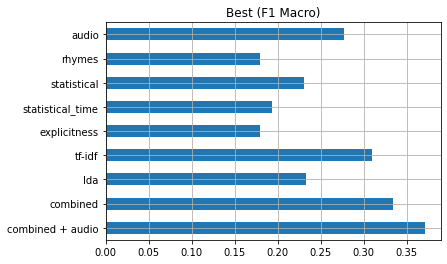

In [2]:
best_score = approach_results.max(axis=1)

ax = best_score.plot.barh(
    title='Best (F1 Macro)',
    grid=True,
)
ax.set_ylabel('')
ax.invert_yaxis()
plt.savefig('../results/best_score.eps', bbox_inches='tight')

\begin{tabular}{llllllr}
\toprule
{} & Extra Trees & Neural Network & Random Forest &    SVM &    kNN &   Best \\
features         &             &                &               &        &        &        \\
\midrule
uniform random   &         --- &            --- &           --- &    --- &    --- &  0.156 \\
audio            &       0.187 &           0.25 &           0.2 &  0.191 &  0.277 &  0.277 \\
rhymes           &       0.107 &          0.105 &         0.116 &  0.179 &  0.157 &  0.179 \\
statistical      &       0.166 &          0.199 &         0.169 &  0.193 &  0.231 &  0.231 \\
statistical\_time &        0.14 &          0.123 &         0.131 &  0.194 &  0.176 &  0.194 \\
explicitness     &       0.077 &          0.089 &         0.077 &  0.179 &  0.063 &  0.179 \\
tf-idf           &       0.141 &           0.31 &         0.152 &  0.211 &  0.203 &  0.310 \\
lda              &       0.177 &          0.171 &         0.183 &  0.219 &  0.233 &  0.233 \\
combined         &       0.156

,Extra Trees,Neural Network,Random Forest,SVM,kNN,Best
features,,,,,,
uniform random,---,---,---,---,---,0.156
audio,0.187,0.25,0.2,0.191,0.277,0.277
rhymes,0.107,0.105,0.116,0.179,0.157,0.179
statistical,0.166,0.199,0.169,0.193,0.231,0.231
statistical_time,0.14,0.123,0.131,0.194,0.176,0.194
explicitness,0.077,0.089,0.077,0.179,0.063,0.179
tf-idf,0.141,0.31,0.152,0.211,0.203,0.310
lda,0.177,0.171,0.183,0.219,0.233,0.233
combined,0.156,0.334,0.162,0.214,0.237,0.334


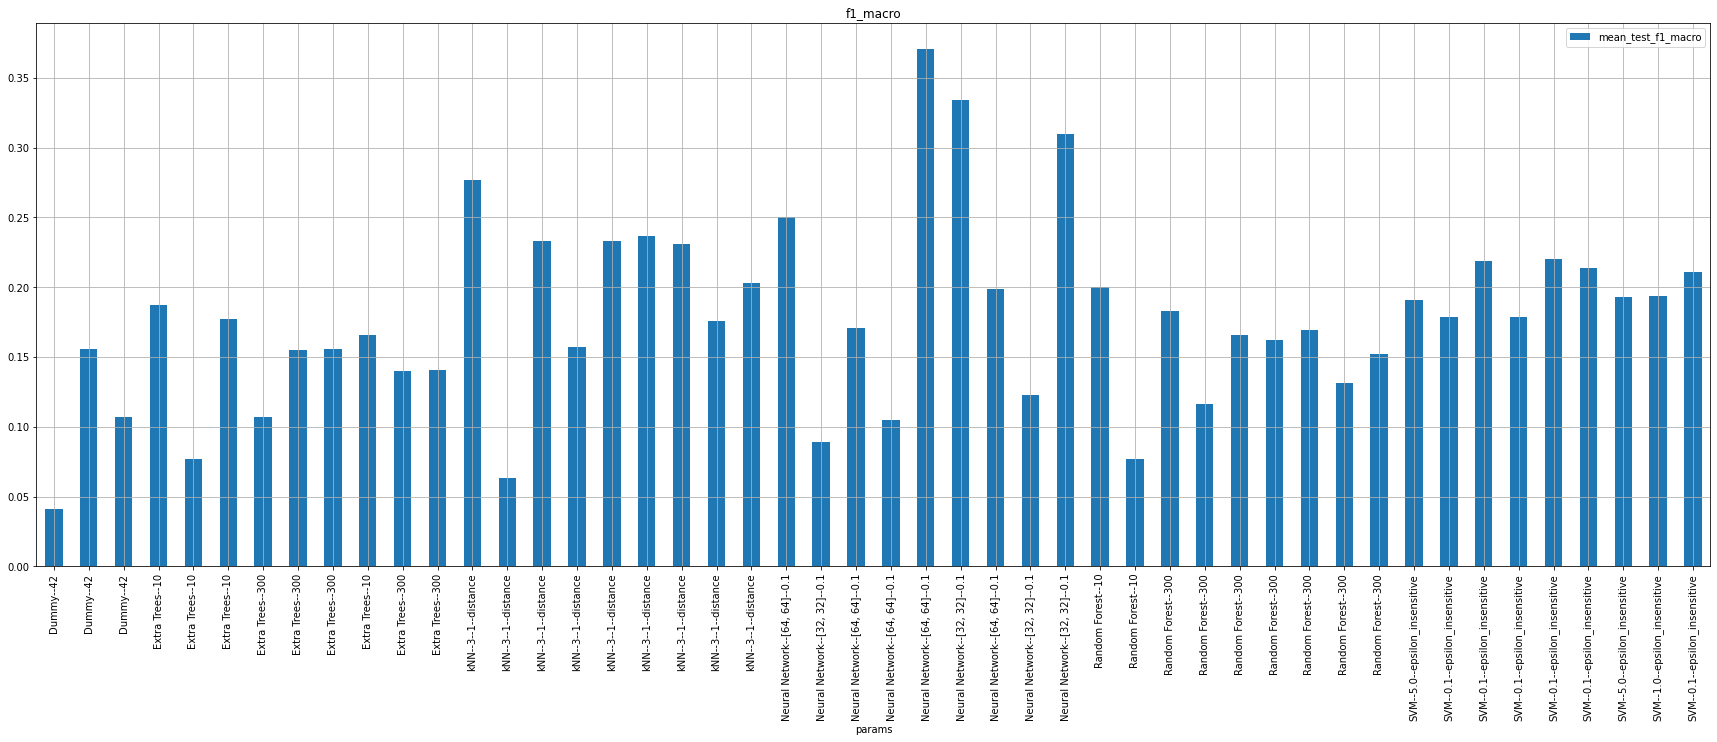

In [3]:
best_score = pd.concat([dummy_results, best_score])
best_score = pd.DataFrame(best_score, columns=['Best'])

approach_results = approach_results.join(best_score, how='right')
approach_results.drop('most frequent', inplace=True)
approach_results.drop('stratified random', inplace=True)
approach_results.fillna('---', inplace=True)

print(approach_results.to_latex())
display(approach_results)

best_results['params'] = best_results[['model', *model_params]].agg(combine, axis=1)

best_results[['sourcefile', score, 'params']].plot.bar(
        x='params',
        title=score_name,
        grid=True,
        figsize=(30, 10),
    )

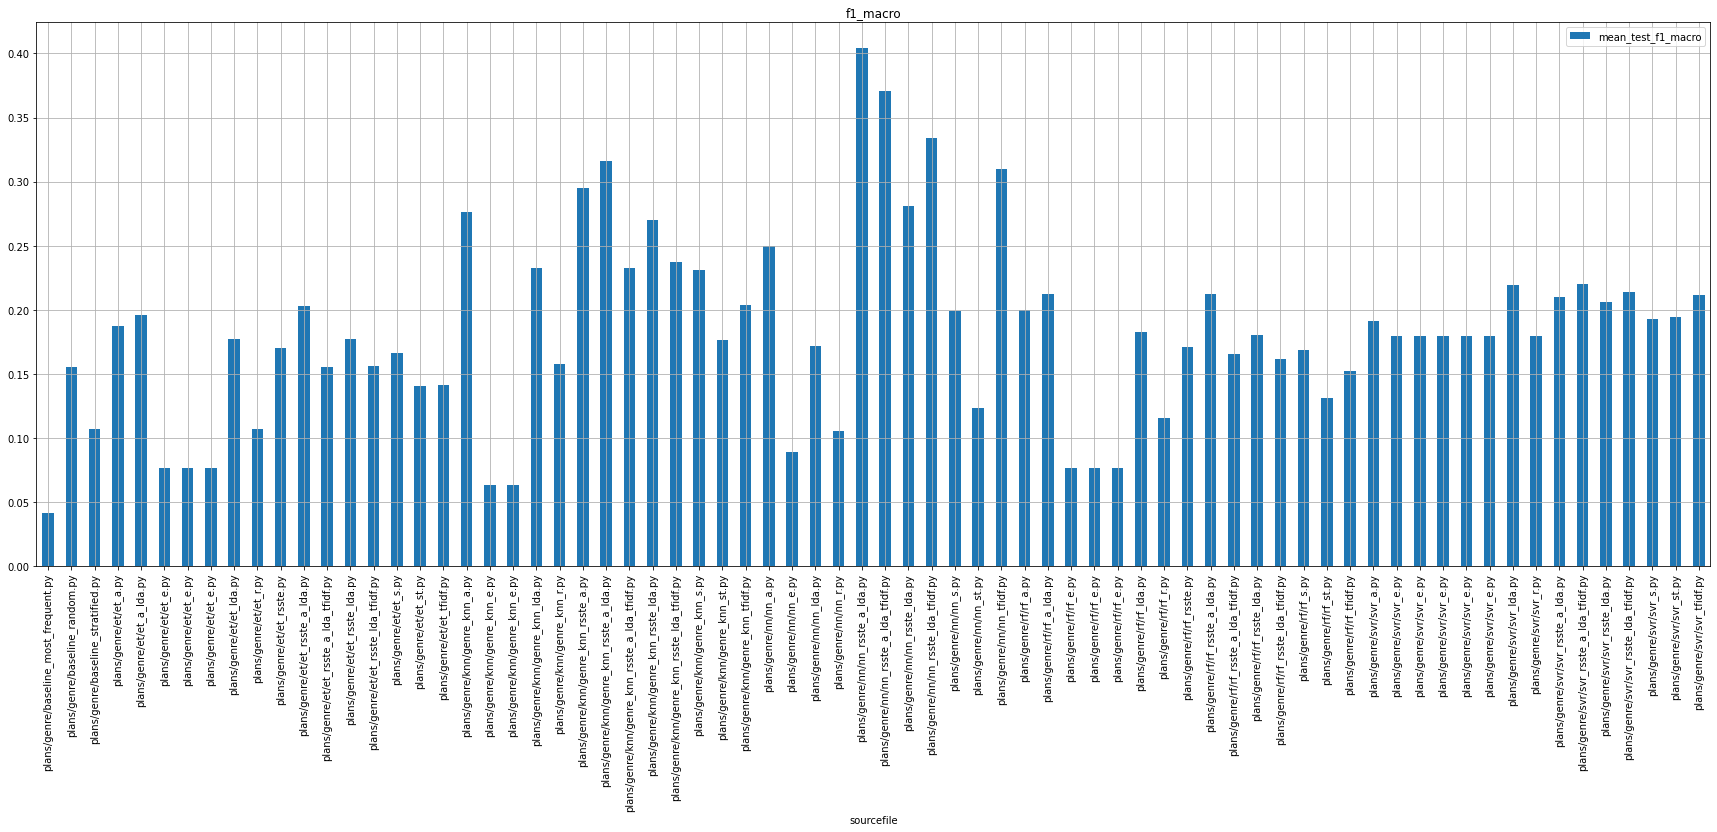

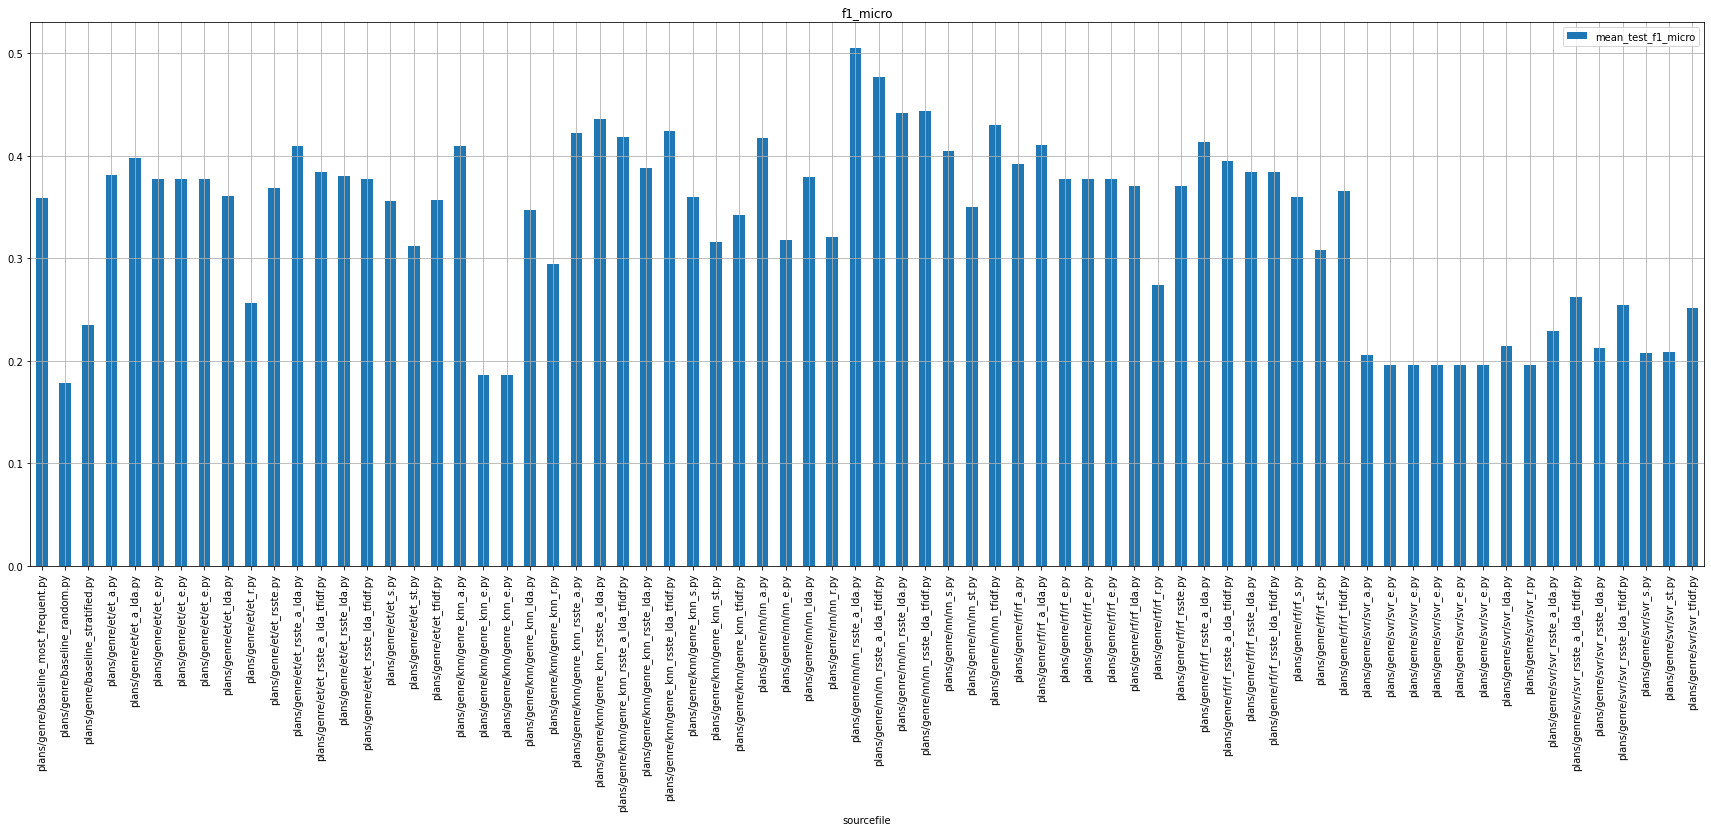

In [4]:
plot_best_results('f1_macro', result_path='../results')
plot_best_results('f1_micro', result_path='../results')

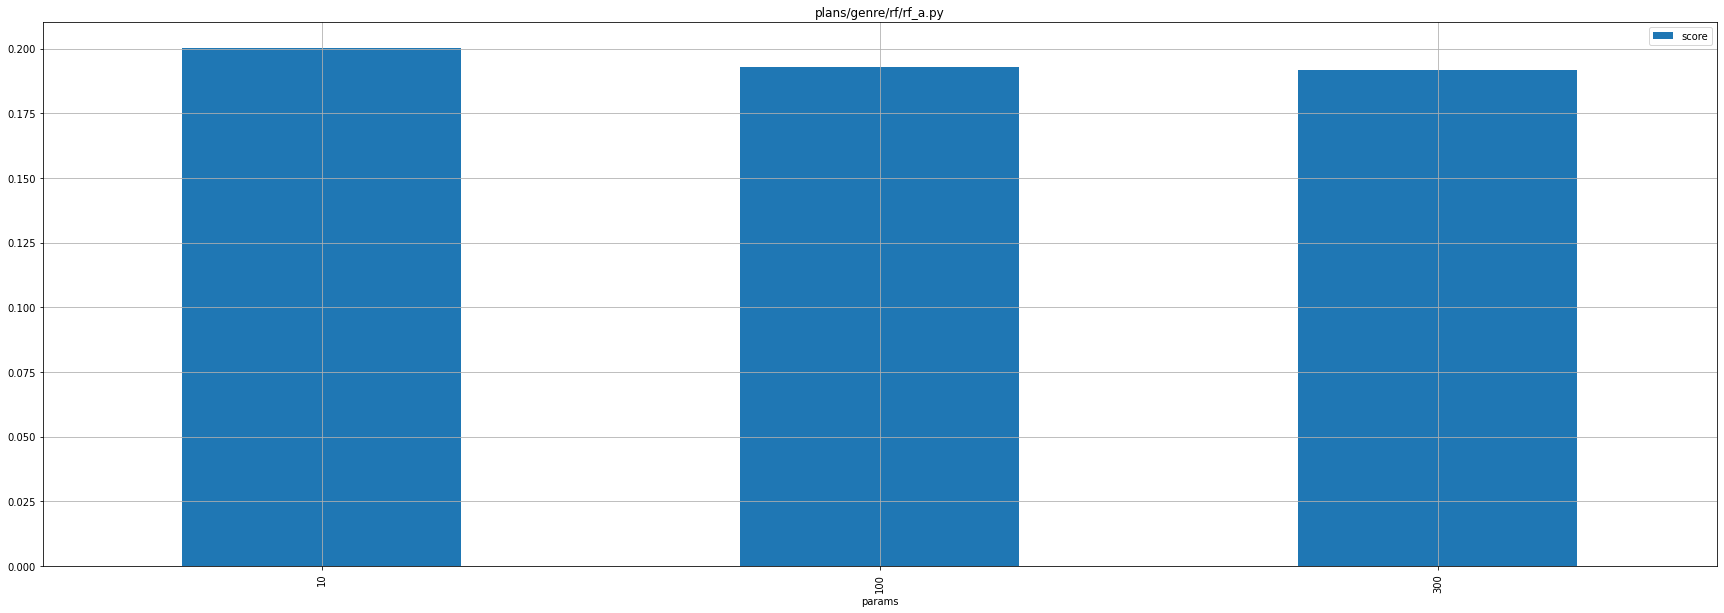

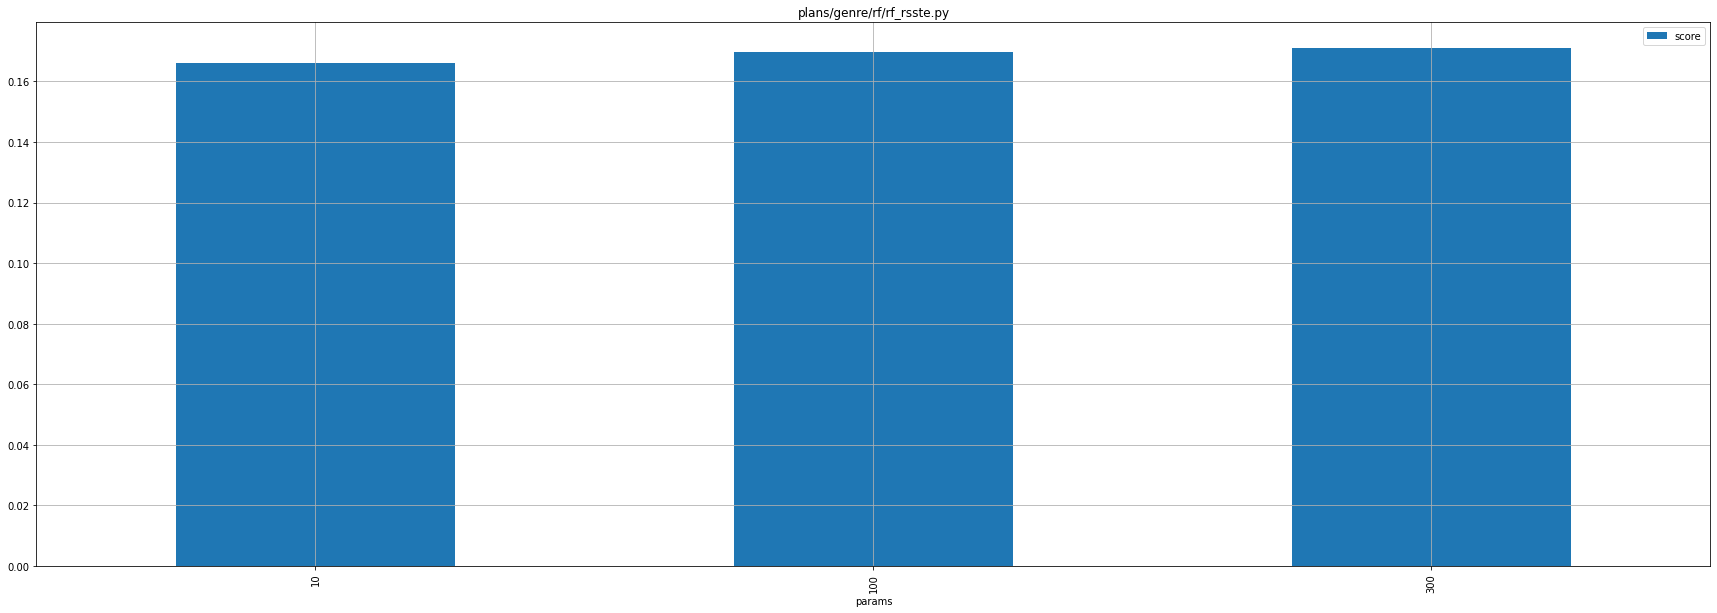

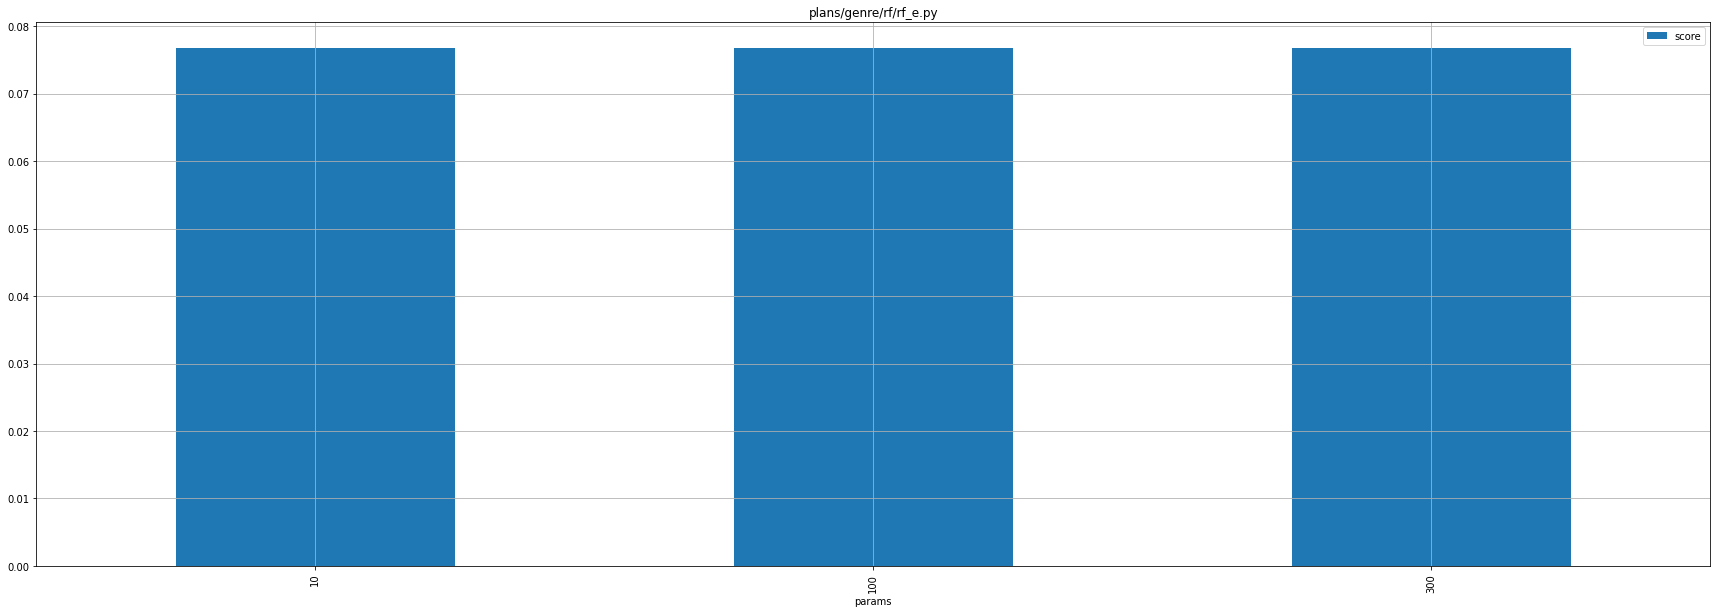

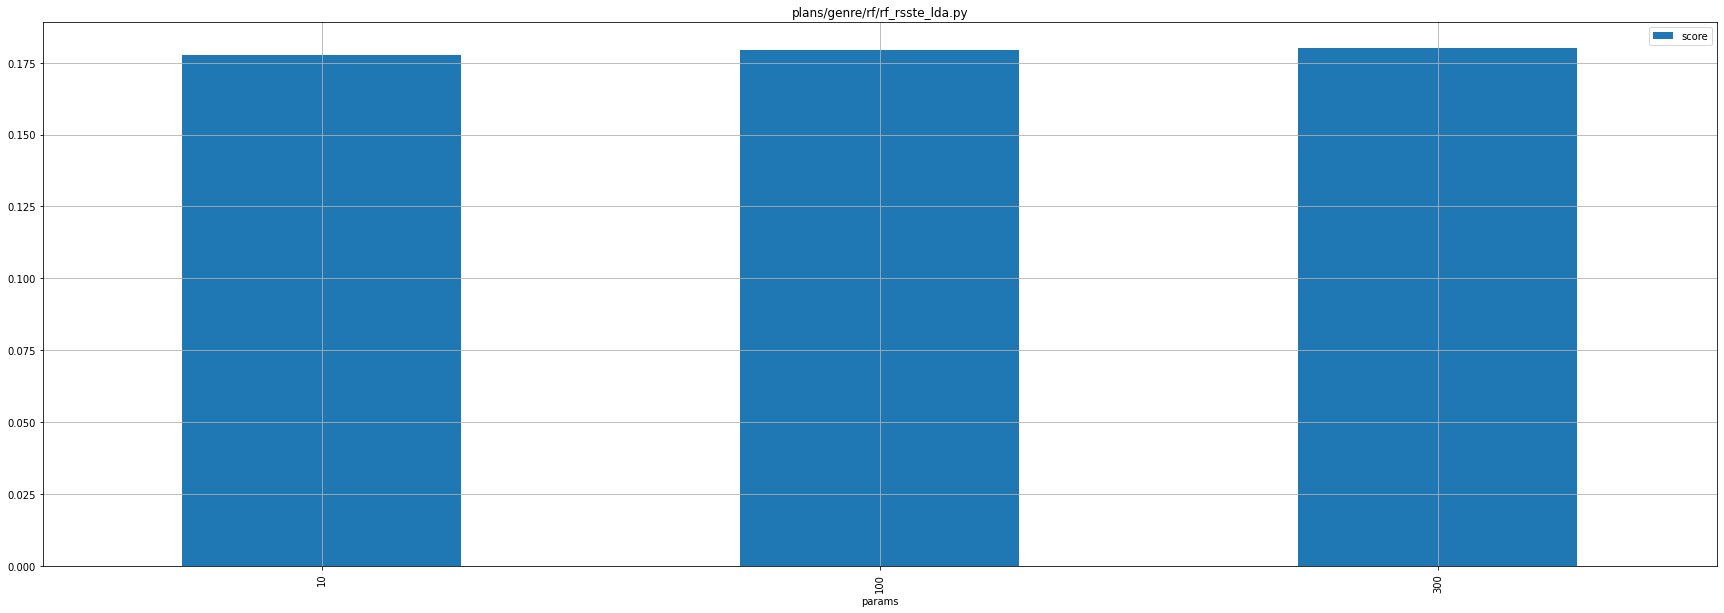

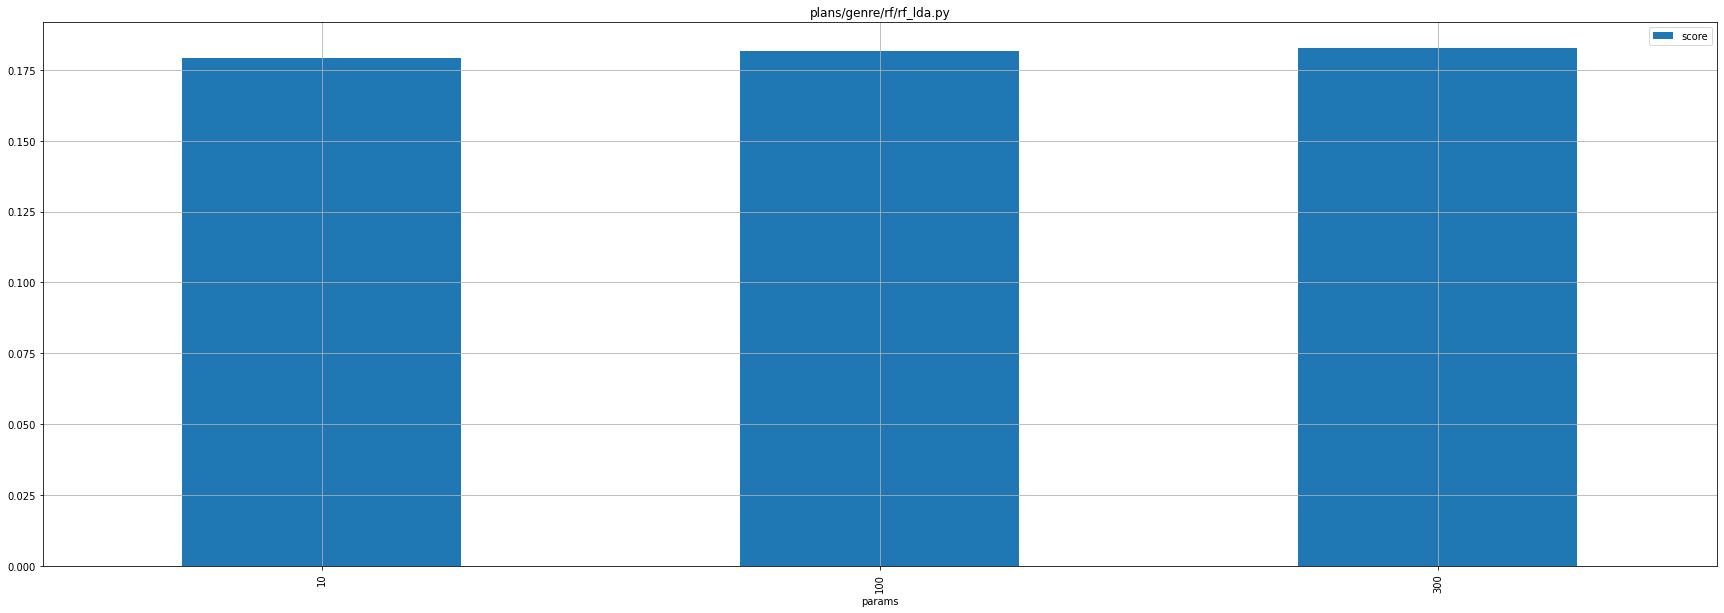

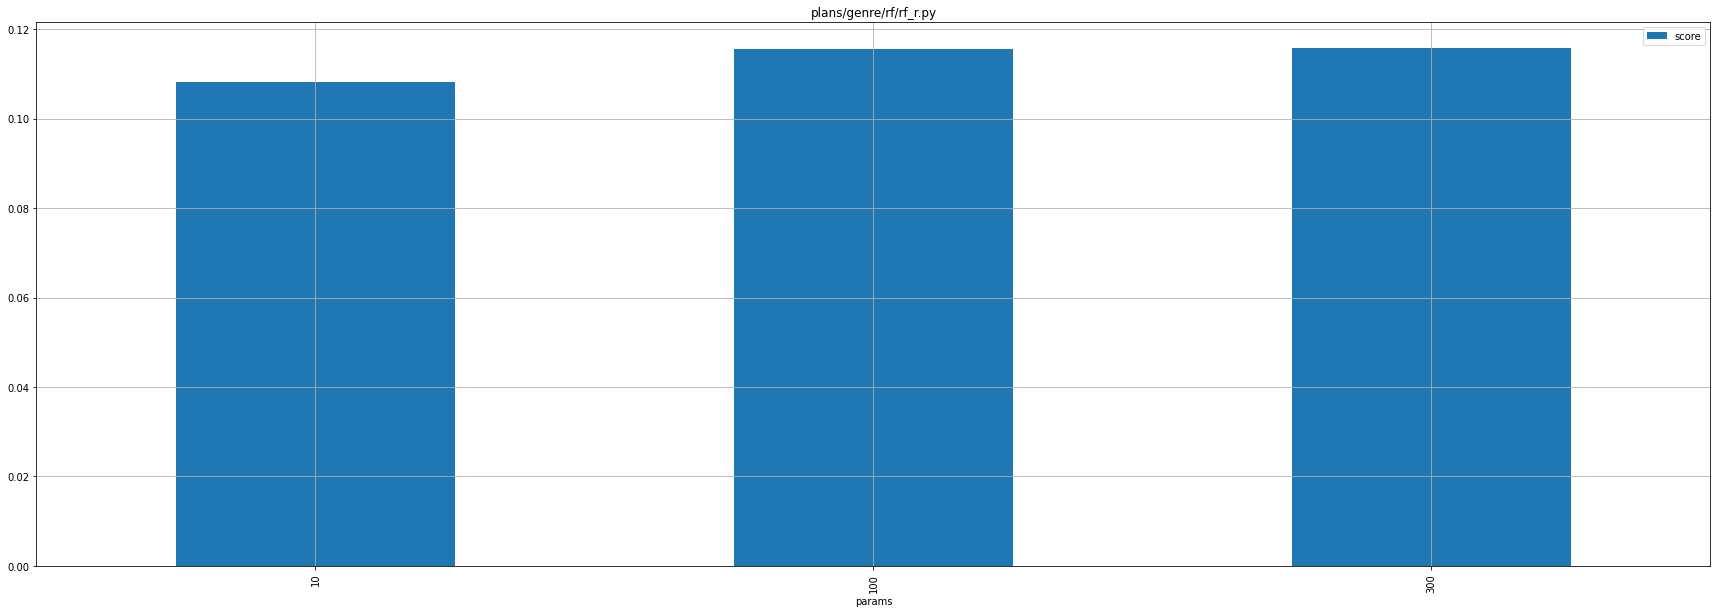

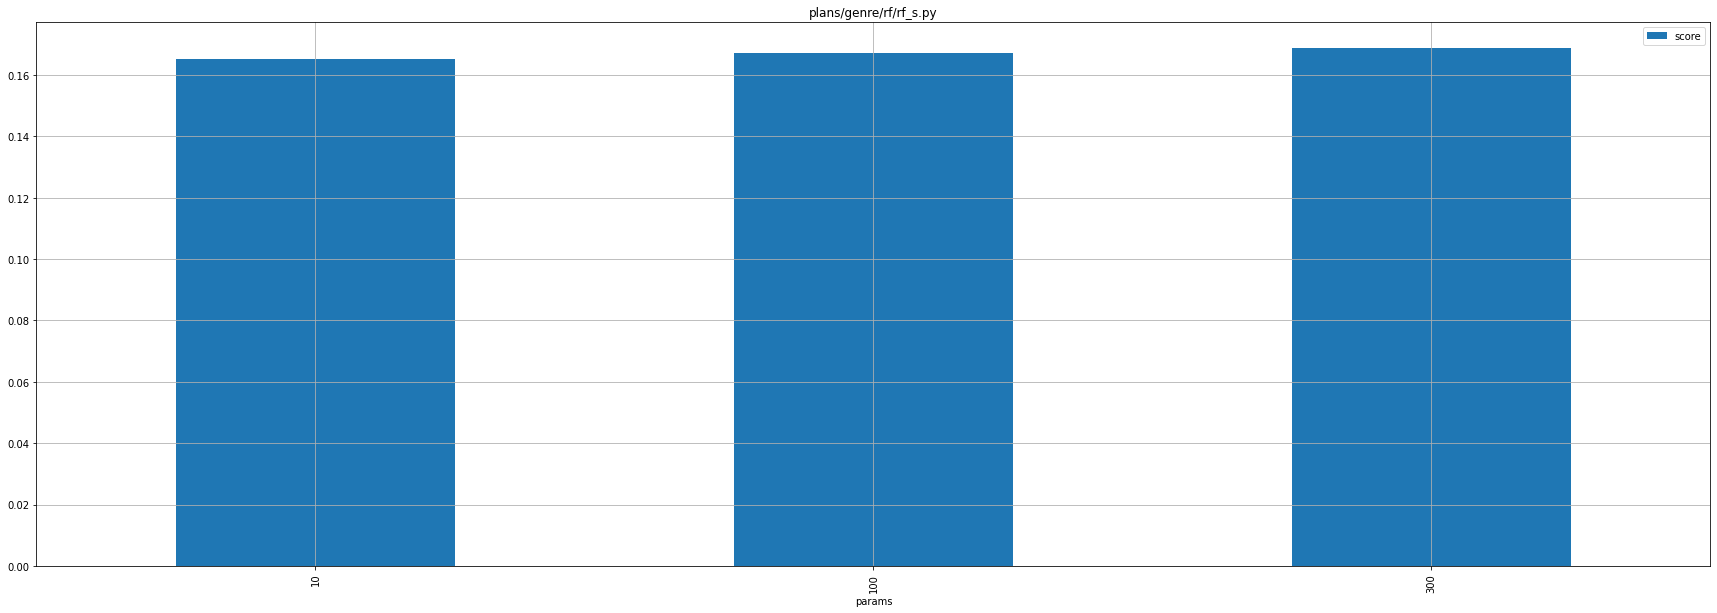

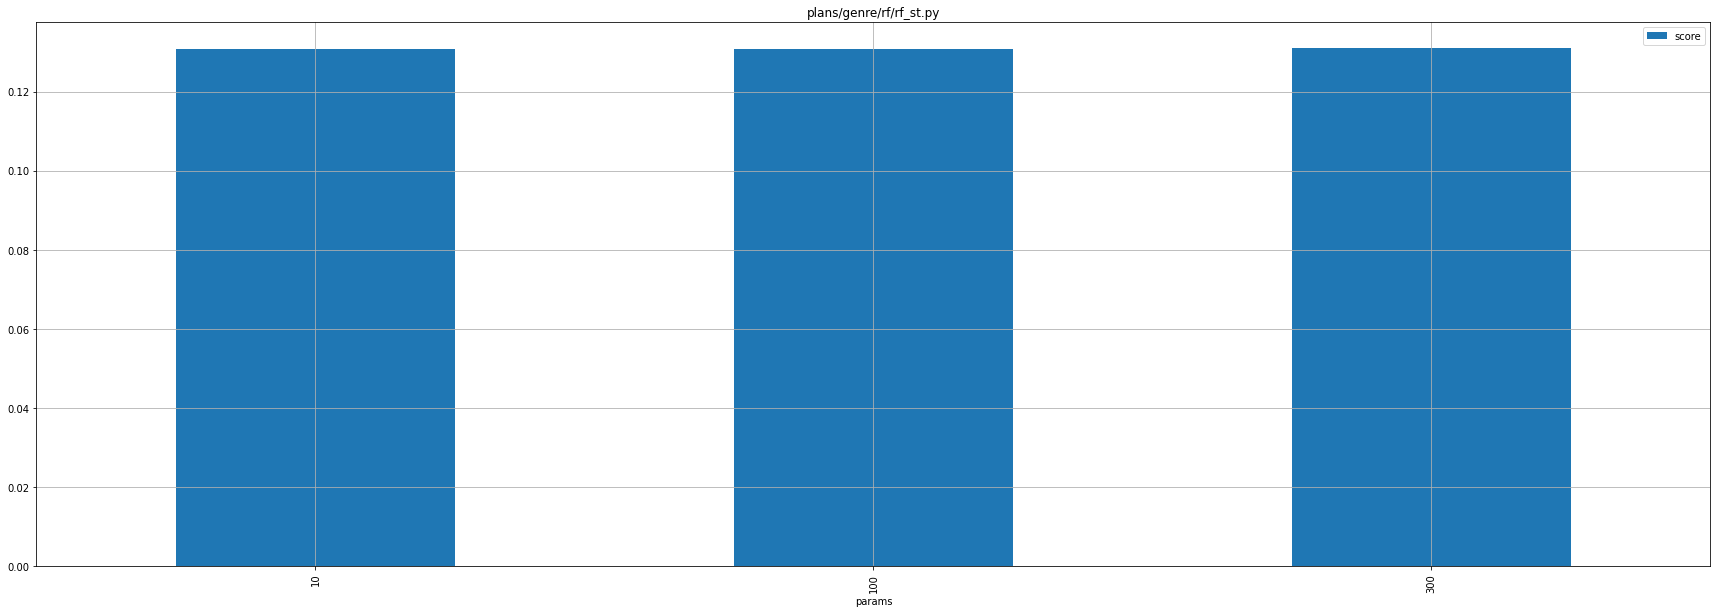

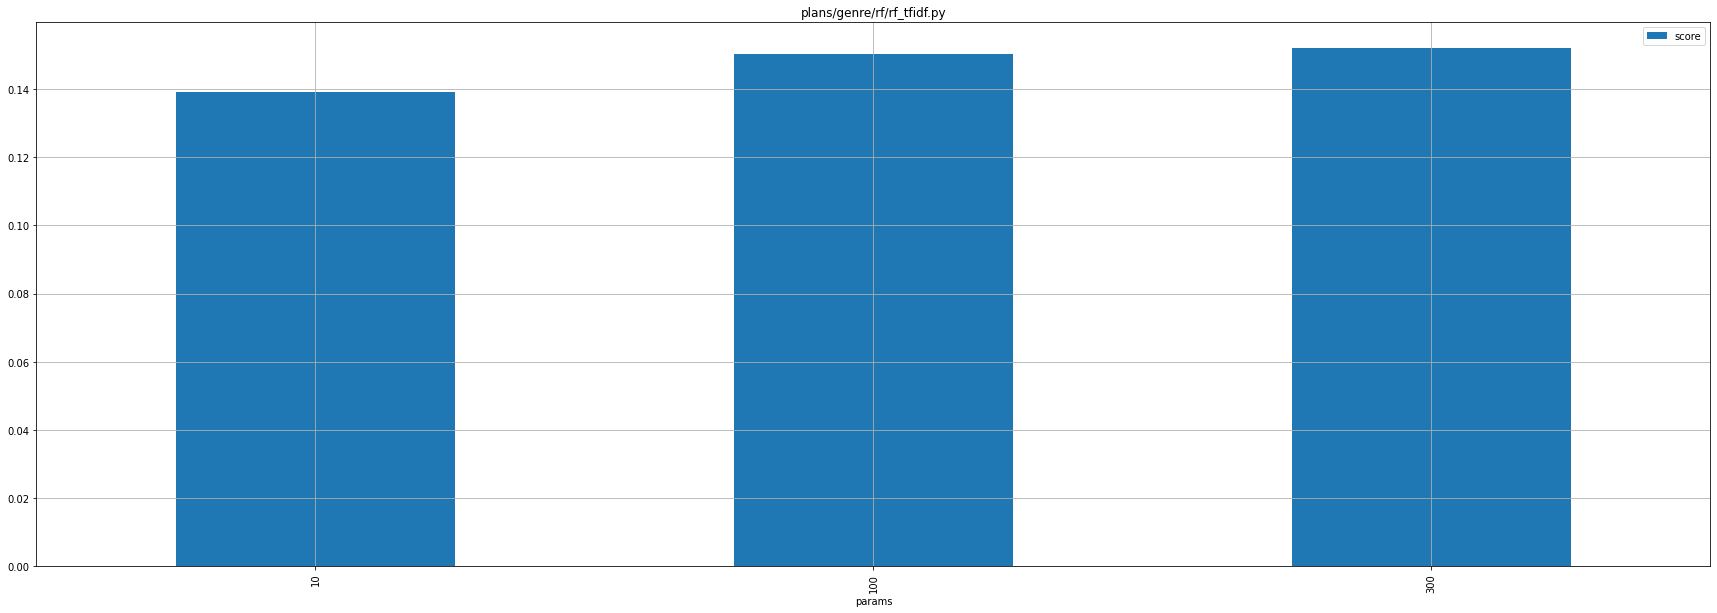

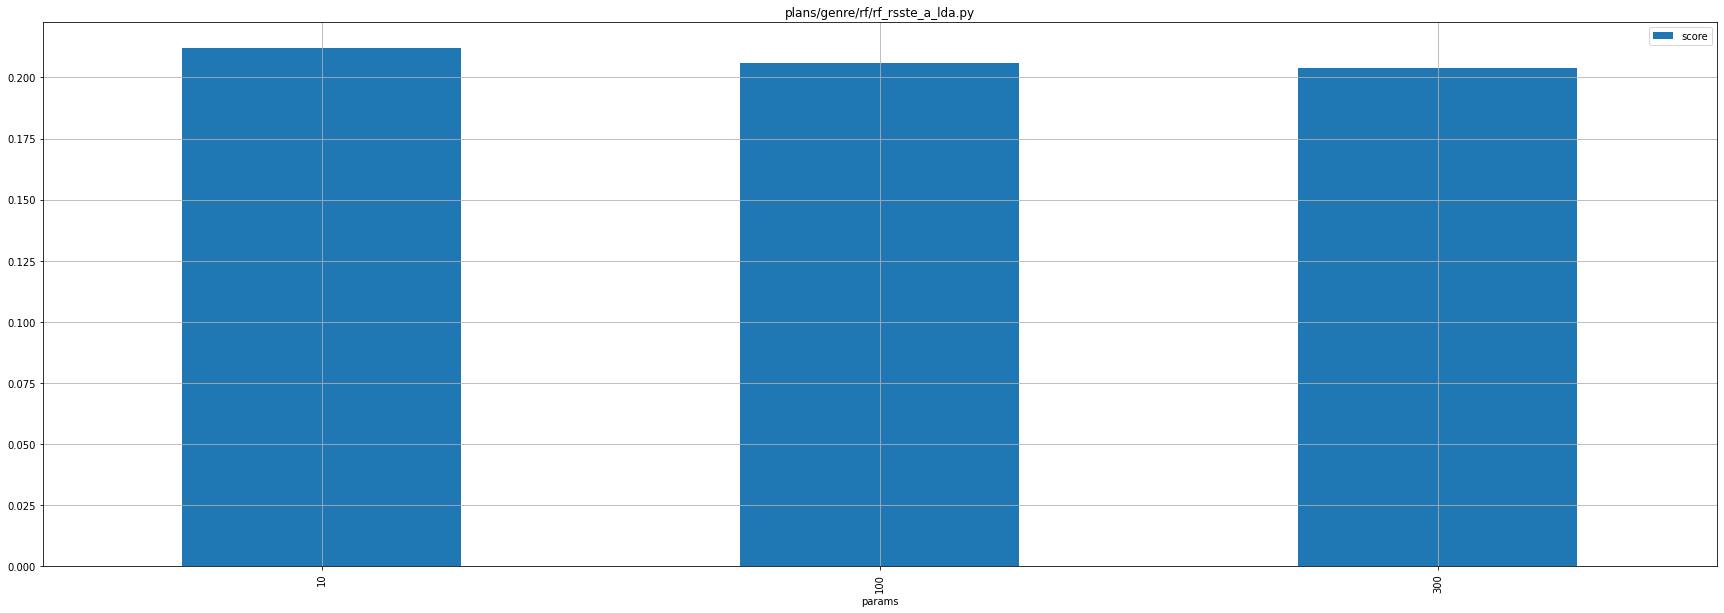

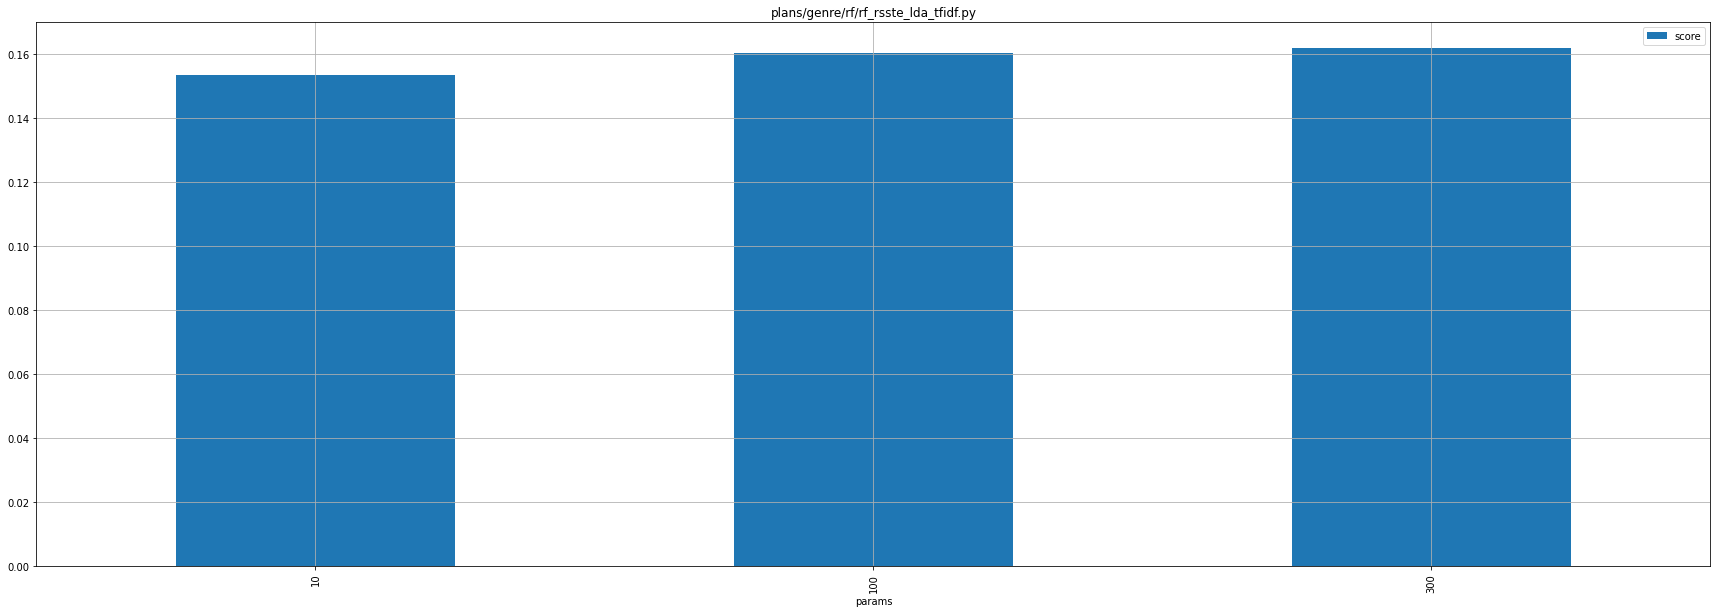

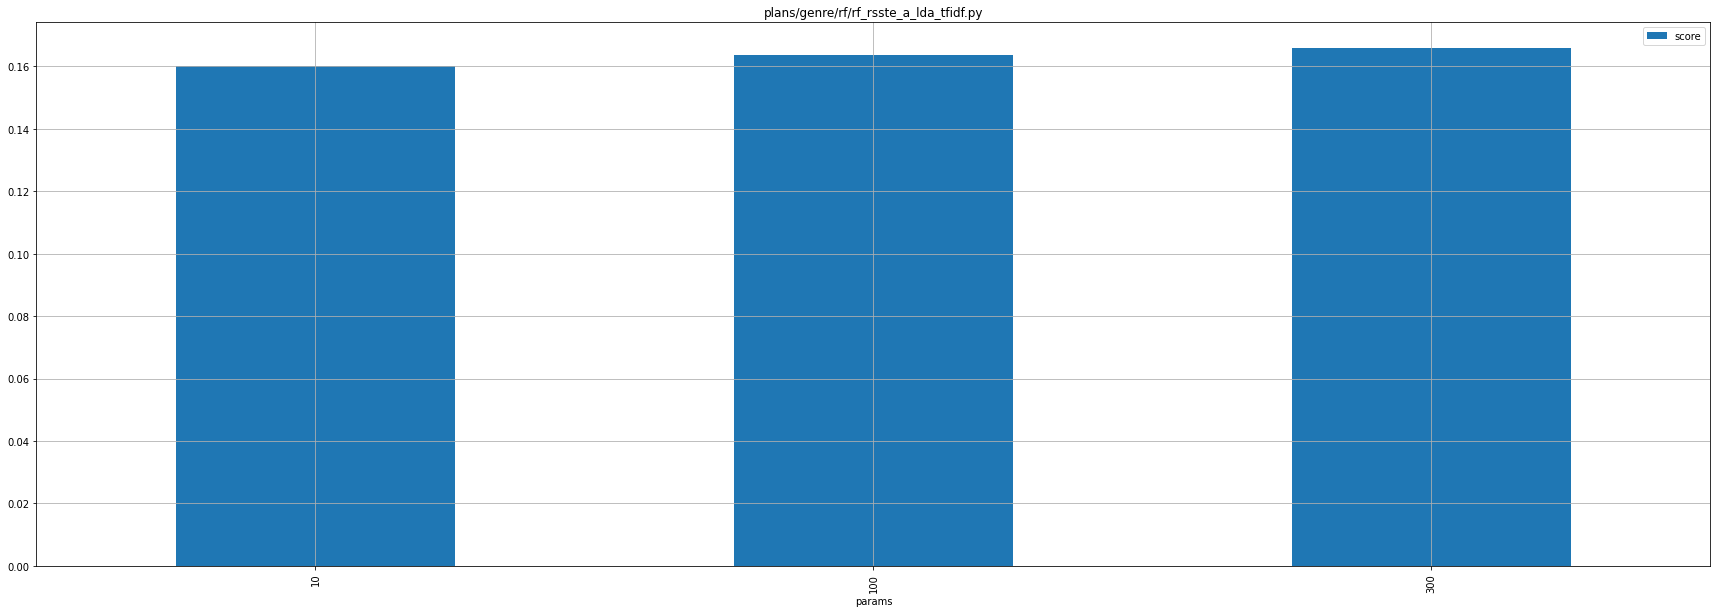

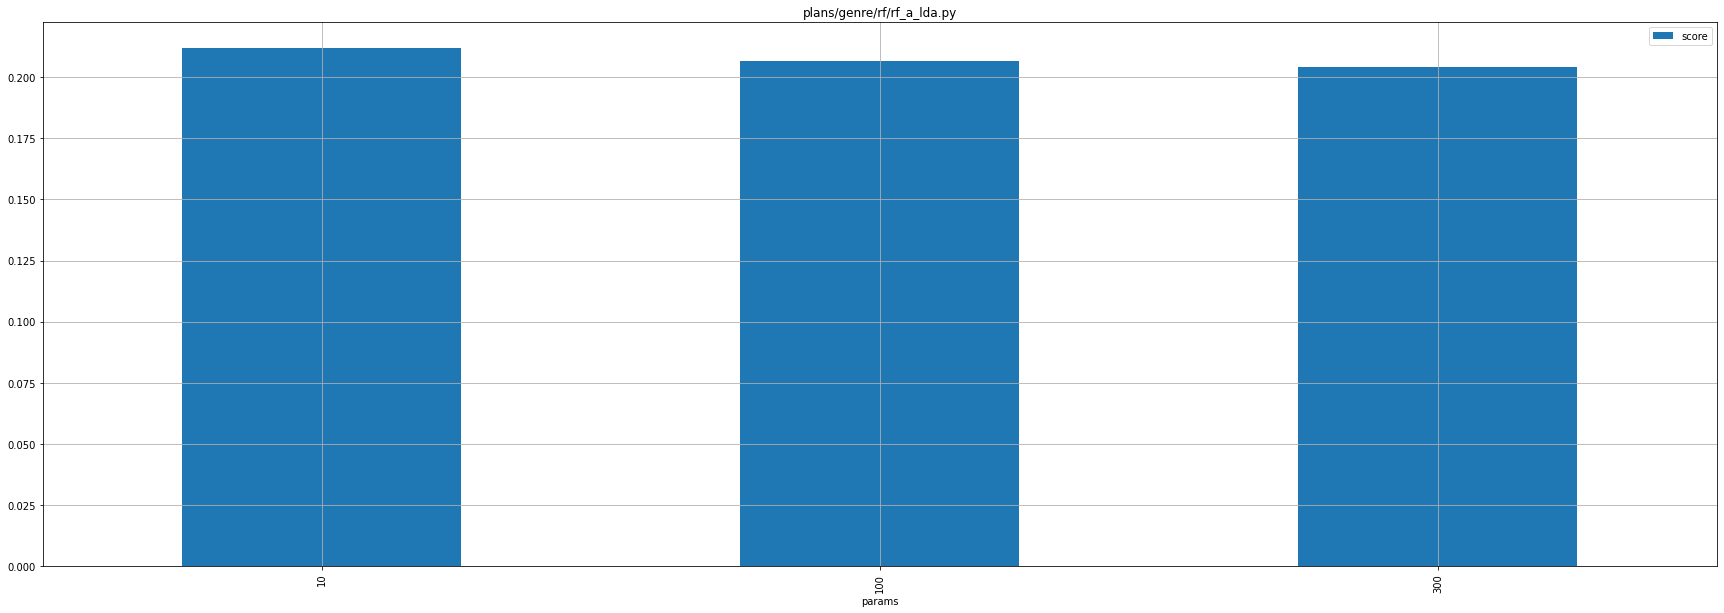

In [5]:
from nlp4musa2020.analytics import get_results

results = get_results(project_name='nlp4musa2020')

results = results[results['sourcefile'].str.contains('genre/rf/')]

from dbispipeline.analytics import extract_gridsearch_parameters

for i in range(1,len(results) + 1):
    knn_result = extract_gridsearch_parameters(results.head(i).tail(1), score_name='mean_test_f1_macro')
    params=[i for i in knn_result.columns if i.startswith('model__')]
    title = knn_result['sourcefile'][0]
    knn_result = knn_result[['score', *params]]
    knn_result['params'] = knn_result['model__n_estimators']
    knn_result.plot.bar(grid=True, x='params', title=str(title), figsize=(30,10),)
